In [1]:
import time

import cv2
import jax
import numpy as np
from matplotlib import pyplot as plt

import trax
from trax import layers as tl
from trax.shapes import signature
from trax.supervised import lr_schedules, training

In [2]:
%matplotlib inline

In [3]:
# Use the tensorflow-numpy backend.
trax.fastmath.set_backend("tensorflow-numpy")
print(trax.fastmath.backend_name())

tensorflow-numpy


In [4]:
# https://github.com/google/flax/blob/9349a3d740918f8df49058e853f521d28181677d/linen_examples/mnist/mnist.ipynb
# Helper functions for images.
def show_img(img, ax=None, title=None):
    """Shows a single image."""
    if ax is None:
        ax = plt.gca()
    ax.imshow(img[..., 0], cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    if title:
        ax.set_title(title)


def show_img_grid(imgs, titles):
    """Shows a grid of images."""
    n = int(np.ceil(len(imgs) ** 0.5))
    _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
    for i, (img, title) in enumerate(zip(imgs, titles)):
        show_img(img, axs[i // n][i % n], title)

## Import Data

In [5]:
train_stream = trax.data.TFDS(
    "mnist", data_dir="./mnist_data2/", keys=("image", "label"), train=True
)()
eval_stream = trax.data.TFDS(
    "mnist", data_dir="./mnist_data2/", keys=("image", "label"), train=False
)()

`train_stream` and `eval_stream` are generators. `next(train_stream)` return a tuple *(image, label)*. 

Let check an image.

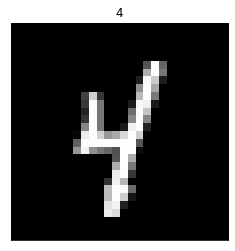

In [6]:
img, label = next(train_stream)
show_img(img, title=str(label))

In [7]:
def random_shift(X):
    dx, dy = np.random.choice(np.arange(-2, 3), size=2, p=[0.1, 0.1, 0.6, 0.1, 0.1])
    X = np.roll(X, dy, axis=0)
    X = np.roll(X, dx, axis=1)
    return X

## Function to rotate images

In [9]:
# https://stackoverflow.com/questions/9041681/opencv-python-rotate-image-by-x-degrees-around-specific-point
def rotate_image(g):
    """
    Randomly rotate a image from (-10 degree to 10 degree).
    """
    for tup in g:
        image, label = tup

        angle = np.random.choice(
            np.arange(-10, 15, 5), size=1, p=[0.1, 0.1, 0.6, 0.1, 0.1]
        )

        row, col, _ = image.shape
        center = tuple(np.array([row, col]) / 2)
        rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
        new_image = cv2.warpAffine(image, rot_mat, (col, row))

        yield (new_image[:, :, None], label)


# def rotateimage():
#     return lambda g: rotate_image(g)

## Function to shift images

In [10]:
def shift_image(g):
    """
    Randomly shift the image up/down/left or right base on the given probability.
    """
    dx, dy = np.random.choice(
        np.arange(-2, 3), size=2, p=[0.075, 0.075, 0.7, 0.075, 0.075]
    )

    for tup in g:
        X, y = tup

        X = np.roll(X, dy, axis=0)

        X = np.roll(X, dx, axis=1)
        for dxy in [dx, dy]:
            if dxy < 0:
                X[dxy:, :] = 0
            if dxy > 0:
                X[:dxy, :] = 0

        yield tuple((X, y))


# def shiftimage():
#     return lambda g: shift_image(g)

We can also use lambda function shown [here](https://trax-ml.readthedocs.io/en/latest/trax.data.html).

```python
def random_shift(X):
    dx, dy = np.random.choice(
        np.arange(-2, 3), size=2, p=[0.075, 0.075, 0.7, 0.075, 0.075]
    )
    
    X = np.roll(X, dy, axis=0)
    X = np.roll(X, dx, axis=1)
    
    for dxy in [dx, dy]:
        if dxy < 0:
            X[dxy:, :] = 0
        if dxy > 0:
            X[:dxy, :] = 0
            
    return X
```

And the data pipeline can be written using a lambda function:
```python
train_data_pipeline = trax.data.Serial(
        lambda g: map(
            lambda x: (random_shift(x[0]), x[1]), g
        ),  # shift image using random_shift function: x[0]=image,x[1]=label
    trax.data.Batch(3),
    trax.data.Shuffle(),
    trax.data.AddLossWeights(),
)
```

In [11]:
train_data_pipeline = trax.data.Serial(
    shift_image,
    rotate_image,
    trax.data.Batch(40),
    trax.data.Shuffle(),
    trax.data.AddLossWeights(),
)

In [12]:
eval_data_pipeline = trax.data.Serial(
    trax.data.Batch(20), trax.data.AddLossWeights(),
)

In [13]:
train_batch = train_data_pipeline(train_stream)
eval_batch = eval_data_pipeline(eval_stream)

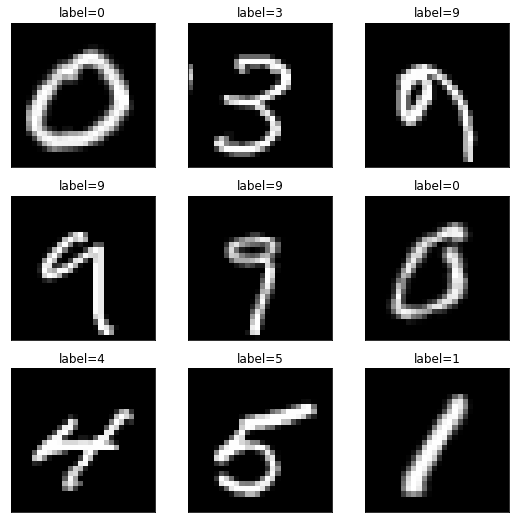

In [14]:
images = next(train_batch)
show_img_grid(
    [images[0][idx] for idx in range(9)],
    [f"label={images[1][idx]}" for idx in range(9)],
)

In [141]:
def get_model(n_output_classes=10):
    model = tl.Serial(
        tl.ToFloat(),
        tl.Conv(32, (3, 3), (1, 1), "SAME"),
        tl.LayerNorm(),
        tl.Relu(),
        tl.AvgPool(strides=(2,2)),
        tl.Conv(64, (3, 3), (1, 1), "SAME"),
        tl.LayerNorm(),
        tl.Relu(),
        tl.AvgPool(strides=(2,2)),
        tl.Flatten(),
        tl.Dense(256),
        tl.Relu(),
        tl.Dense(n_output_classes),
        tl.LogSoftmax(),
    )
    return model

In [142]:
model = get_model()

In [136]:
print(model)

Serial[
  ToFloat
  Conv
  LayerNorm
  Serial[
    Relu
  ]
  MaxPool(2,2)
  Conv
  LayerNorm
  Serial[
    Relu
  ]
  MaxPool(2,2)
  Flatten_keep1
  Dense_256
  Serial[
    Relu
  ]
  Dense_10
  LogSoftmax
]


## Make sure the model is working.

In [56]:
model.init(trax.shapes.signature(images))

(((),
  (ndarray<<tf.Tensor: shape=(5, 5, 1, 16), dtype=float32, numpy=
   array([[[[ 5.91100194e-02,  7.42365792e-02,  4.12834734e-01,
             -6.59424663e-01, -2.39922386e-02, -3.18918377e-01,
             -7.88308159e-02,  3.63800019e-01,  6.30915016e-02,
             -9.55872890e-03, -3.47371221e-01, -1.22353315e-01,
              4.70524102e-01, -1.15175627e-01, -1.00883290e-01,
             -3.54151309e-01]],
   
           [[-4.66780335e-01,  1.81568116e-01,  8.73525560e-01,
             -8.62190500e-02,  4.61799741e-01,  1.51982412e-01,
             -1.15936518e-01, -4.46387142e-01, -1.73292667e-01,
             -1.17932297e-01,  1.38963908e-01,  1.95878986e-02,
             -2.54022032e-01, -5.04785292e-02, -1.48370132e-01,
             -1.77843884e-01]],
   
           [[-7.58526385e-01,  1.34381980e-01, -6.34019613e-01,
             -3.96193862e-01, -4.17205662e-01,  9.24890190e-02,
             -5.73916286e-02,  4.91443694e-01, -2.68169612e-01,
              1.50136769

In [57]:
model(images)

(ndarray<<tf.Tensor: shape=(40, 10), dtype=float32, numpy=
 array([[-2.9722693 , -4.252158  , -3.0531437 , -1.0045846 , -2.2159855 ,
         -3.5954227 , -2.9320014 , -3.8534117 , -4.923906  , -1.1943221 ],
        [-2.3031063 , -4.557092  , -3.1261766 , -0.8969562 , -2.524972  ,
         -3.3742464 , -2.6220512 , -3.849649  , -5.0705404 , -1.4990557 ],
        [-3.3077242 , -4.269676  , -2.9998207 , -0.5171206 , -2.7020864 ,
         -3.1602228 , -3.5374167 , -3.8792336 , -4.1650896 , -2.0509052 ],
        [-3.3614984 , -3.9202263 , -3.9911637 , -0.4495175 , -2.990291  ,
         -3.720287  , -2.9372625 , -4.8209248 , -5.682685  , -1.8965079 ],
        [-3.60244   , -4.605439  , -2.4567509 , -0.5783191 , -3.7254725 ,
         -3.6583397 , -2.4172654 , -2.9666986 , -6.1480474 , -2.0911927 ],
        [-3.7094529 , -4.290477  , -2.8947887 , -0.692044  , -3.7405124 ,
         -3.086965  , -2.6704342 , -1.9327414 , -4.0642033 , -2.2498388 ],
        [-3.9933312 , -4.930169  , -3.1608465 ,

In [158]:
train_task = training.TrainTask(
    labeled_data=train_batch,
    loss_layer=tl.WeightedCategoryCrossEntropy(),
    optimizer=trax.optimizers.Adam(0.00005),
    #     lr_schedule=lr_schedules.warmup_and_rsqrt_decay(5, 0.1),
    n_steps_per_checkpoint=100,
)

eval_task = training.EvalTask(
    labeled_data=eval_batch,
    metrics=[tl.WeightedCategoryCrossEntropy(), tl.Accuracy()],
    n_eval_batches=20,
)

In [159]:
!rm -r mnist_cnn_model

In [172]:
training_loop = training.Loop(
    model, train_task, eval_tasks=[eval_task], output_dir="./mnist_cnn_model"
)

training_loop.run(1000)


Step   4100: Ran 100 train steps in 10.86 secs
Step   4100: train WeightedCategoryCrossEntropy |  0.11098009
Step   4100: eval  WeightedCategoryCrossEntropy |  0.04259281
Step   4100: eval                      Accuracy |  0.98750000

Step   4200: Ran 100 train steps in 8.36 secs
Step   4200: train WeightedCategoryCrossEntropy |  0.06507728
Step   4200: eval  WeightedCategoryCrossEntropy |  0.05611138
Step   4200: eval                      Accuracy |  0.98000000

Step   4300: Ran 100 train steps in 8.51 secs
Step   4300: train WeightedCategoryCrossEntropy |  0.06066537
Step   4300: eval  WeightedCategoryCrossEntropy |  0.06836465
Step   4300: eval                      Accuracy |  0.97750000

Step   4400: Ran 100 train steps in 8.23 secs
Step   4400: train WeightedCategoryCrossEntropy |  0.07124132
Step   4400: eval  WeightedCategoryCrossEntropy |  0.03294150
Step   4400: eval                      Accuracy |  0.99500000

Step   4500: Ran 100 train steps in 8.27 secs
Step   4500: train W

## Make predictions for a batch

In [64]:
images = next(eval_batch)

In [65]:
y_pred = np.argmax(model(images[0]), axis=1)

In [66]:
y = images[1]

In [67]:
np.where(y != y_pred)

(array([12]),)

In [75]:
print(f"predicted = {y_pred},\n actual   = {y}")

predicted = [9 6 7 9 4 3 0 6 4 6 4 1 8 2 4 4 9 1 7 3],
 actual   = [9 6 7 9 4 3 0 6 4 6 4 1 9 2 4 4 9 1 7 3]


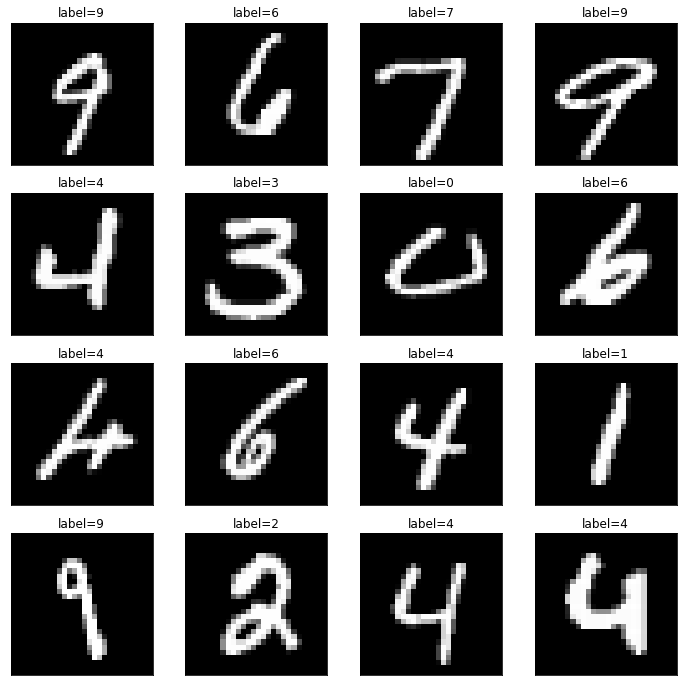

In [78]:
show_img_grid(
    [images[0][idx] for idx in range(16)],
    [f"label={images[1][idx]}" for idx in range(16)],
)

## Make a prediction for a single image.

In [79]:
np.argmax(model(images[0][2][None, :]))  # Add a batch dimension

7

## Check Accuracy of Evaluation Dataset

In [177]:
eval_stream = trax.data.TFDS(
    "mnist", data_dir="./mnist_data2/", keys=("image", "label"), train=False
)()

y_pred = []
y = []
count = 0
start_time=time.time()
while True:
    count += 1
   
    image, label = next(eval_stream)
    y.append(label)
    y_pred.append(np.argmax(model(image[None, :]), axis=1)[0])

    if count % 1000 == 0:
        end_time=time.time()
        print(f"Finish {count} image prediction in {end_time-start_time:.3f} secs")
        start_time=end_time
    
    if count == 10000:
        break

Finish 1000 image prediction in 16.671 secs
Finish 2000 image prediction in 16.584 secs
Finish 3000 image prediction in 16.616 secs
Finish 4000 image prediction in 16.385 secs
Finish 5000 image prediction in 17.079 secs
Finish 6000 image prediction in 16.649 secs
Finish 7000 image prediction in 16.576 secs
Finish 8000 image prediction in 16.493 secs
Finish 9000 image prediction in 17.668 secs
Finish 10000 image prediction in 14.524 secs


In [178]:
y_pred = np.array(y_pred)
y=np.array(y)

In [179]:
len(np.where(y_pred==y)[0])/len(y)*100

98.56

In [173]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir mnist_cnn_model --reload_multifile True

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6008 (pid 83629), started 19:46:18 ago. (Use '!kill 83629' to kill it.)